# Time series example
Vamos a intentar pronosticar el alquiler de bicicletas 'compartidas'


In [33]:
#!pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor

In [6]:
df_raw = pd.read_csv("../data/raw/bike_sharing_train.csv")
df_test = pd.read_csv("../data/raw/bike_sharing_test.csv")

In [7]:
df_raw.info()
#10886 obs, 12 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
df_raw.sample(10)
#Con el chunk anterior y este vemos que datetime no está como type object y adentro tiene fechas

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5431,2012-01-01 09:00:00,1,0,0,1,10.66,13.635,93,7.0015,13,27,40
1665,2011-04-15 07:00:00,2,1,0,1,16.40,20.455,71,11.0014,10,139,149
1310,2011-03-19 11:00:00,1,0,0,1,18.86,22.725,36,30.0026,90,106,196
2621,2011-06-17 03:00:00,2,0,1,1,22.96,26.515,94,7.0015,1,5,6
3156,2011-08-01 10:00:00,3,0,1,1,35.26,37.880,36,11.0014,27,70,97
9516,2012-09-19 21:00:00,3,0,1,1,20.50,24.240,59,11.0014,25,324,349
1131,2011-03-11 19:00:00,1,0,1,1,12.30,13.635,56,22.0028,7,111,118
3624,2011-09-01 22:00:00,3,0,1,2,27.06,31.060,57,15.0013,34,145,179
3208,2011-08-03 14:00:00,3,0,1,2,31.16,35.605,58,15.0013,43,104,147
6987,2012-04-09 11:00:00,2,0,1,1,21.32,25.000,27,27.9993,96,127,223


In [9]:
df_interim = df_raw.copy()

In [12]:
#Pasamos datetime a datetime:
df_interim['datetime'] = pd.to_datetime(df_interim['datetime'])

#Cuando trabajamos con series de tiempo el tiempo (la fecha) tiene que ser el índice:
df_interim = df_interim.set_index(df_interim['datetime'])


#Vamos a separar hora, día, mes en columnas:
df_interim['hour'] = df_interim.index.hour
df_interim['day'] = df_interim.index.day
df_interim['month'] = df_interim.index.month

#Dropping irrelevant cols:
df_interim = df_interim.drop(['datetime', 'casual', 'registered'], axis = 1)

In [13]:
df_interim.sample(10)
#Ahora datetime es el índice (está más abajo) y tenemos por separado hour, day y month

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2012-02-03 09:00:00,1,0,1,1,9.84,11.365,65,12.9980,270,9,3,2
2012-09-07 09:00:00,3,0,1,1,28.70,33.335,79,8.9981,344,9,7,9
2011-06-09 08:00:00,2,0,1,2,31.16,36.365,70,7.0015,432,8,9,6
2012-10-06 13:00:00,4,0,0,2,26.24,31.060,57,35.0008,710,13,6,10
2012-09-16 23:00:00,3,0,0,1,22.14,25.760,68,7.0015,94,23,16,9
2012-01-03 04:00:00,1,0,1,1,6.56,7.575,55,16.9979,5,4,3,1
2011-06-06 13:00:00,2,0,1,1,31.98,34.090,35,0.0000,180,13,6,6
2011-06-08 06:00:00,2,0,1,1,26.24,28.790,89,8.9981,116,6,8,6
2012-06-14 04:00:00,2,0,1,2,24.60,31.060,56,16.9979,6,4,14,6


In [14]:
df = df_interim.copy()

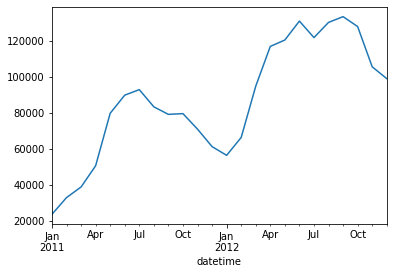

In [15]:
df['count'].resample('M').sum().plot()
plt.show()
#Resample hace una agregación, similar a groupby
#M es mes, después va el tipo de agregación que quiero, en este caso suma

#Tendencia a suba de las operaciones a partir de enero 2012

In [17]:
df.describe().T
#Con la T la trasponemos para que se vea mejor

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000
hour,10886.0,11.541613,6.915838,0.00,6.0000,12.000,18.0000,23.0000


In [ ]:
#Pending: hacer histograma

In [18]:
df
#La unidad mínima del index es una hora porque no hay variaciones ni en min ni en seg, todas son 00:00

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


In [19]:
#Gráfica de temporalidad
res = seasonal_decompose(df['count'].values, period=24) #Lo vamos a hacer por bloques de día, por eso period = 24
res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

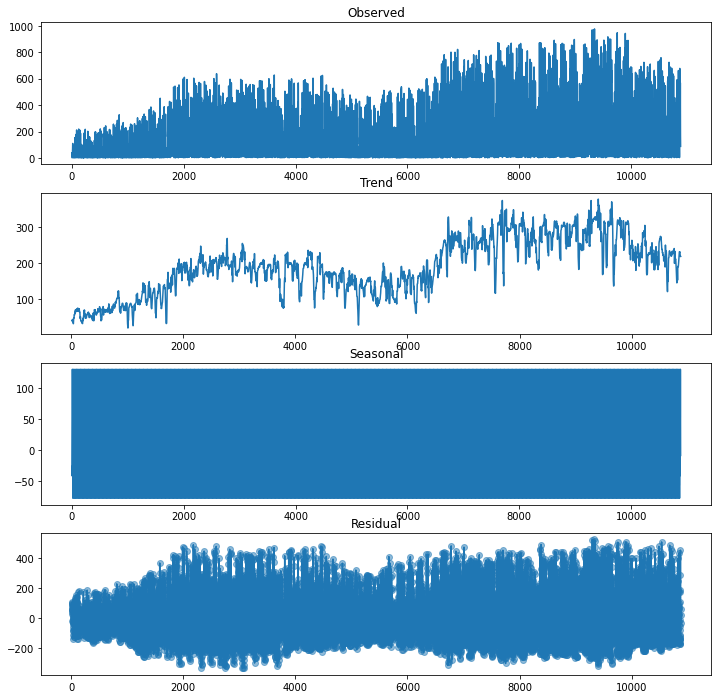

In [20]:
fig, ax = plt.subplots(4, figsize = (12, 12))
ax[0].set_title('Observed')
ax[0].plot(res_observed)
ax[1].set_title('Trend')
ax[1].plot(res_trend)
ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)
ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y = res_residual, x = range(len(res_residual)), alpha = 0.5)
plt.show()

In [21]:
#Gráfica de temporalidad
#Vamos a hacer el gráfico de nuevo pero menos apretado (tomando menos observaciones, las últimas 250)
res = seasonal_decompose(df['count'].values[-250:], period=24) 
res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

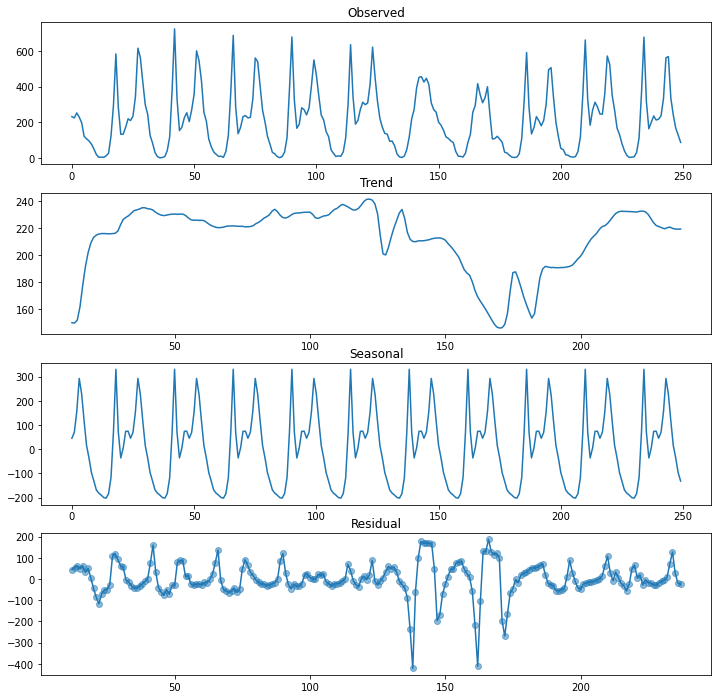

In [22]:
fig, ax = plt.subplots(4, figsize = (12, 12))
ax[0].set_title('Observed')
ax[0].plot(res_observed)
ax[1].set_title('Trend')
ax[1].plot(res_trend)
ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)
ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y = res_residual, x = range(len(res_residual)), alpha = 0.5)
plt.show()

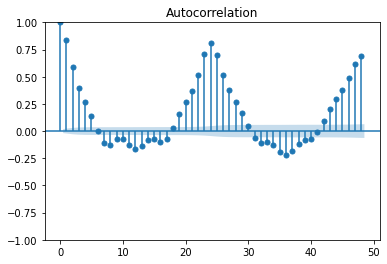

In [23]:
#Gráfica de autocorrelación
plot_acf(df['count'].values, lags = 48) #48 pasos hacia atrás (días)
plt.show()

A partir de esto sabemos:
* La unidad de pronóstico no puede ser muy grande
* Parece que hay un patrón o de horas o de semanas (en el gráfico de seasonal el patrón se repite)

Ahora podemos modelizar ML:

In [24]:
X = df.drop('count', axis = 1)
y = df['count']

horizon = 168
#24*7 = 168

X_train, X_test = X.iloc[:-horizon], X.iloc[-horizon:,:]
#Vamos a usar un bloque de una semana para testear y un espacio grande para trainear

y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [25]:
model = LGBMRegressor(random_state = 123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
#Calculamos error medio absoluto y mean sq error
mae = np.round(mean_absolute_error(y_test, y_pred), 1)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 1)

print(f'MAE:', mae)
print(f'RMSE:', rmse)

MAE: 53.8
RMSE: 73.8


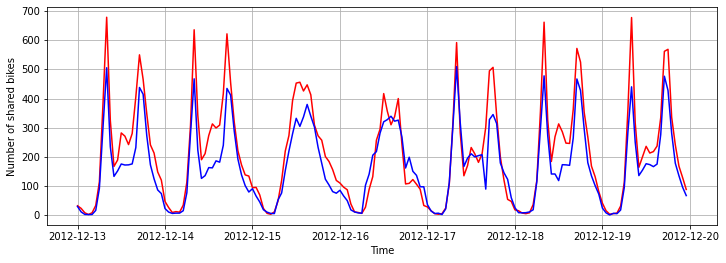

In [27]:
fig = plt.figure(figsize = (12, 4))
plt.plot(y_test, color = 'r')
plt.plot(pd.Series(y_pred, index = y_test.index), color = 'b')
plt.xlabel('Time')
plt.ylabel('Number of shared bikes')
plt.grid()
plt.show()

#En el último bloque que tomamos (168 últimos ptos / días), la realidad es el rojo y lo predicho es azul


In [28]:
#Variance importance
df_var_imp = pd.DataFrame({'var': model.feature_name_, 'imp': model.feature_importances_}).sort_values(by='imp', ascending = False)
df_var_imp

#Las variables clave para el pronóstico del uso de las bicis: horas, días, humedad

,var,imp
8,hour,752
9,day,401
6,humidity,392
4,temp,323
2,workingday,253
10,month,226
5,atemp,222
7,windspeed,190
0,season,102
3,weather,87


In [29]:
df['count_lag_week'] = df['count'].shift(24*7)
df = df.dropna(how = 'any', axis = 0)

MAE: 32.7
RMSE: 48.4


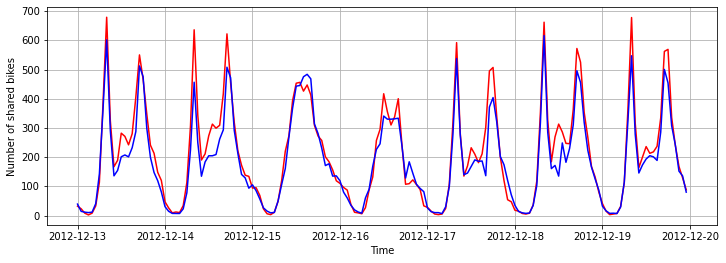

In [31]:
X = df.drop('count', axis = 1)
y = df['count']

horizon = 168
#24*7 = 168

X_train, X_test = X.iloc[:-horizon], X.iloc[-horizon:,:]
#Vamos a usar un bloque de una semana para testear y un espacio grande para trainear

y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

model = LGBMRegressor(random_state = 123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


#Calculamos error medio absoluto y mean sq error
mae = np.round(mean_absolute_error(y_test, y_pred), 1)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 1)

print(f'MAE:', mae)
print(f'RMSE:', rmse)

fig = plt.figure(figsize = (12, 4))
plt.plot(y_test, color = 'r')
plt.plot(pd.Series(y_pred, index = y_test.index), color = 'b')
plt.xlabel('Time')
plt.ylabel('Number of shared bikes')
plt.grid()
plt.show()

#Tanto el MAE como el RMSE bajaron porque lo tuneamos

In [32]:
df_var_imp = pd.DataFrame({'var': model.feature_name_, 'imp': model.feature_importances_}).sort_values(by='imp', ascending = False)
df_var_imp

#Ahora count lag week (var que creamos) es la segunda más importante para la predicción

,var,imp
8,hour,703
11,count_lag_week,506
9,day,347
6,humidity,309
4,temp,296
2,workingday,237
5,atemp,170
10,month,154
7,windspeed,120
3,weather,70


Con MAE y RMSE ya podemos tomar decisiones en lo que respecta al equipo de operaciones y cuántas bicicletas debería haber a disposición, etc.